In [1]:
checkpoint = 'axial_segmentation_effseg_095521-epoch-51.pth'

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, f"train_axial_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"segmentation_axial_labels")

In [5]:
from efficientunet import *

def get_axial_segmentation_model(checkpoint):
    model = get_efficientunet_b5(out_channels=2, concat_input=True, pretrained=True)
    
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint))
    model.load_state_dict(state["model"])
    model.eval()
    return model.to(device)
    
model = get_axial_segmentation_model(checkpoint)

In [6]:
UID = '1.2.826.0.1.3680043.1636'
# axial_index = 205
# label = Image.open(os.path.join(LABEL_DIR, UID, f"{axial_index}.png"))
# label = np.array(label) / 256

# print(label.min(), label.max())

In [7]:
def get_bbox_class(label, bbox):
    """
    label 은 0.125 의 단위로, 
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox
    area = label[ymin:ymax, xmin:xmax]
    
    plt.imshow(label)
    plt.axvline(xmin)
    plt.axvline(xmax)
    plt.axhline(ymin)
    plt.axhline(ymax)
    # print(area)
    result = np.mean(area[area>0])
    result = np.round(result / 0.125)
    
    return result

# get_bbox_class(label, [270, 180, 320, 190])

In [8]:
def get_axial_boundary(seg, pixel_spacing, throw=100, tol=0.2, max_mm=100):
    image_size = seg.shape[0]
    min_size = min(image_size, max_mm / pixel_spacing)
    
    rows, columns = seg.nonzero()
    rows.sort()
    columns.sort()
    
    throw = min(len(rows) // 2, throw)
    
    if(len(rows)) == 0:
        return 0, 0, image_size, image_size
    
    xmin, xmax = columns[throw], columns[-throw]
    ymin, ymax = rows[throw], rows[-throw]
    
    w = (xmax - xmin) * (1 + tol)
    h = (ymax - ymax) * (1 + tol)
    new_size = max(w, h, min_size)
    new_size = min(image_size, new_size)
    
    xcenter, ycenter = (xmax + xmin) / 2, (ymax + ymin) / 2
    
    xmin = min(image_size - new_size, xcenter - new_size / 2)
    xmin = max(0, xmin)
    
    ymin = min(image_size - new_size, ycenter - new_size / 2)
    ymin = max(0, ymin)
    
    return xmin, ymin, xmin + new_size, ymin + new_size

# UID = '1.2.826.0.1.3680043.10062'


# _, axs = plt.subplots(28, 10, figsize=(100, 280))

# for i in range(280):
    
#     axial_index = i
#     label = Image.open(os.path.join(LABEL_DIR, UID, f"{axial_index}.png"))
#     label = np.array(label) / 256
#     xmin, ymin, xmax, ymax = get_axial_boundary(label, 0.2539)
#     axs[i//10, i % 10].imshow(label)
#     axs[i//10, i % 10].axvline(xmin)
#     axs[i//10, i % 10].axvline(xmax)
#     axs[i//10, i % 10].axhline(ymin)
#     axs[i//10, i % 10].axhline(ymax)

In [9]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.image_size = image_size

        
        self.transform = A.Compose([
            A.Resize(image_size, image_size),
            ToTensorV2(p=1),
        ])

        self.normalize = T.Normalize(255 * 0.5, 255 * 0.5)

    def forward(self, x):
        augmented = self.transform(image=np.asarray(x))
        x= augmented['image']

        x = self.normalize(x.float())

        return x
    
transform = DataTransform(256)

In [10]:
@torch.no_grad()
def predict(x, model):
    x = x.to(device)
    logits = model(x)

    classification_score, mse_score = logits.sigmoid().chunk(2, dim=1)
    classification_pred = classification_score.gt(0.5).float()
    pred = (classification_pred * mse_score).cpu().numpy()
    
    return pred

In [11]:
# img = Image.open(os.path.join(IMAGES_DIR, UID, '156.jpeg'))
# x = transform(img).unsqueeze(0).to(device)
# print(x.min(), x.max())
# print(x.shape)
# label = predict(x, model)
# print(label.min(), label.max())

# plt.imshow(label.squeeze())
# get_axial_boundary(label.squeeze(), 0.327, throw=50, tol=0.2, max_mm=50)

In [12]:
train_3d_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_train_3d.csv')).set_index('UID')
print(len(train_3d_df))
train_3d_df.head()

2012


,z_spacing,pixel_spacing,aspect,is_flip
UID,,,,
1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0
1.2.826.0.1.3680043.10005,0.625,0.298828,2.091504,0
1.2.826.0.1.3680043.10014,0.800,0.234000,3.418803,0
1.2.826.0.1.3680043.10016,0.313,0.275391,1.136566,0
1.2.826.0.1.3680043.10032,0.625,0.320313,1.951216,0


In [15]:
UID = '1.2.826.0.1.3680043.15105'
# UID = '1.2.826.0.1.3680043.15206'
pixel_spacing = float(train_3d_df.loc[UID, 'pixel_spacing'])

_, axs = plt.subplots(28, 10, figsize=(100, 280))

class_label_list = []

for i in tqdm(range(280)):
    
    index = i
    rpath = os.path.join(IMAGES_DIR, UID, f"{index-2}.jpeg")
    gpath = os.path.join(IMAGES_DIR, UID, f"{index-1}.jpeg")
    bpath = os.path.join(IMAGES_DIR, UID, f"{index}.jpeg")
    r = Image.open(rpath) if os.path.exists(rpath) else Image.open(bpath)
    g = Image.open(gpath) if os.path.exists(gpath) else Image.open(bpath)
    b = Image.open(bpath) 
    
    img = Image.merge("RGB",(r,g,b))
    # print(np.asarray(img).shape)
    x = transform(img).unsqueeze(0).to(device)
    
    # print(x.shape)
    # break
    
    label = predict(x, model)
    label = np.round(label / 0.125) * 0.125
    label = label.squeeze()
    class_label = np.mean(label[label > 0])
    class_label_list.append(class_label)
    xmin, ymin, xmax, ymax = get_axial_boundary(label, pixel_spacing, throw=50, tol=0.2, max_mm=50)
    axs[i//10, i % 10].imshow(label, cmap='nipy_spectral')
    axs[i//10, i % 10].axvline(xmin)
    axs[i//10, i % 10].axvline(xmax)
    axs[i//10, i % 10].axhline(ymin)
    axs[i//10, i % 10].axhline(ymax)
    axs[i//10, i % 10].set_title(class_label)

100%|██████████| 280/280 [00:22<00:00, 12.24it/s]


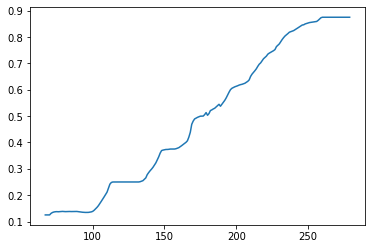

In [16]:
plt.plot(class_label_list)